In [12]:
import sys
import inspect
import numpy as np
import pandas as pd

class Imputer():
    def __init__(self, verbose):
        self.verbose = verbose
        self.DENOM_ROUND = 1e-9
        self.knn_imputer = None
    """
        Helper function to impute the missing values, using the known formula. If one row contains
        more than one missing value among `cols`, the function amounts to do nothing
        Input: 
            - df_: dataframe (copied)
            - cols: all columns involved in the imputation
            - signs: support only either '+' or '-'
        Output:
            - df_: dataframe (imputed)
    """
    def __calculate (self, df_, cols, signs):
        if self.verbose:
            print(f"{sys._getframe(1).f_code.co_name}: total mismatch {self.__check(df_, cols, signs)} rows, \
    imputing {self.__check(df_, cols, signs, na_count=1)} rows with 1 NA!")
        # Impute column by column
        for target, target_col in enumerate(cols):
            mask = df_[target_col].isna() # Extract potential imputable entries in the target column 
            
            # Example: a = b - c - d - e
            # To impute column d, we keep a's and d's sign, and flip all the rest, equivalently a - b + c - e = -d
            if target == 0: 
                flipped_signs = signs
            else: 
                flipped_signs = [sign if i == target or i == 0 else '-' if sign == '+' else '+' for i, sign in enumerate(signs)]
            
            res = pd.Series(0, index=df_.loc[mask].index) # placeholder
            for col, sign in zip(cols, flipped_signs):
                if col == target_col: 
                    continue
                if sign == '+': 
                    res += df_.loc[mask, col]
                else: 
                    res -= df_.loc[mask, col]
            # if there is an initial negative sign before the target column
            df_.loc[mask, target_col] = res if signs[target] == '+' else -res
        # there should be no more rows with only 1 missing values
        assert df_[df_[cols].isna().sum(axis=1) == 1].empty
        # Check NA conditions after the imputation
        if self.verbose:
            print(f"After imputation, there are still {self.__check(df_, cols, signs)} mismatched rows!")
            print("----------------------------------------------------------------")
        return df_
    
    '''
        Helper function to check the number of mismatched rows (with `na_count` NAs) according to the given formula
        Input: 
            - Same as __calculate
            - na_count: number of NAs in the row, 0 <= na_count <= len(cols)
        Output:
            - num_mismatch: number of mismatched rows
    '''
    def __check(self, df_, cols, signs, na_count=None):
        if na_count is None: # full dataset
            df_subset = df_
        else:
            df_subset = df_[df_[cols].isna().sum(axis=1) == na_count]
        left = df_subset[cols[0]]
        right = pd.Series(0, index=left.index)
        for col_right, sign_right in zip(cols[1:], signs[1:]):
            if sign_right == '+': right += df_subset[col_right]
            else: right -= df_subset[col_right]
        num_mismatch = sum(~np.isclose(left - right, 0))
        return num_mismatch

    def impute_margin_fin(self, df_, cols=['margin_fin', 'eqty_tot', 'asst_fixed_fin', 'asst_intang_fixed', 'asst_tang_fixed']):
        if self.verbose: print("Rule: {} = {} - {} - {} - {}".format(*cols))
        return self.__calculate(df_, cols, ['+'] * 2 + ['-'] * 3)
    def impute_cf_operations(self, df_, cols=['cf_operations', 'ebitda', 'profit', 'inc_financing', 'inc_extraord', 'taxes']):
        if self.verbose: print("Rule: {} = {} + {} + {} + {} - {}".format(*cols))
        return self.__calculate(df_, cols, ['+'] * 5 + ['-'])
    def impute_wc_net(self, df_, cols=['wc_net', 'asst_current', 'debt_st']):
        if self.verbose: print("Rule: {} = {} - {}".format(*cols))
        return self.__calculate(df_, cols, ['+'] * 2 + ['-'])
    def impute_prof_operating(self, df_, cols=['prof_operations', 'rev_operating', 'COGS']):
        if self.verbose: print("Rule: {} = {} - {}".format(*cols))
        return self.__calculate(df_, cols, ['+'] * 2 + ['-'])
    def impute_roe(self, df_, cols=['roe', 'profit', 'eqty_tot'], atol=1e-2):
        if self.verbose: print("Rule: {} = {} / {} * 100".format(*cols))
       
        num_mismatch = np.sum(~np.isclose(df_['roe'], df_['profit'] / df_['eqty_tot'] * 100, atol=atol))
        if self.verbose: print(f"{sys._getframe(0).f_code.co_name}: total mismatch {num_mismatch} rows")
       
        df_.loc[df_['roe'].isna(), 'roe'] = (df_['profit'] / (df_['eqty_tot'] + self.DENOM_ROUND) * 100).round(2)
        df_.loc[df_['profit'].isna(), 'profit'] = df_['roe'] * (df_['eqty_tot'] + self.DENOM_ROUND) / 100
        df_.loc[df_['eqty_tot'].isna(), 'eqty_tot'] = df_['profit'] / (df_['roe'] + self.DENOM_ROUND) / 100

        num_mismatch = np.sum(~np.isclose(df_['roe'], df_['profit'] / df_['eqty_tot'] * 100, atol=atol))
        if self.verbose:
            print(f"After imputation, there are still {num_mismatch} mismatched rows!")
            print("----------------------------------------------------------------")
        return df_

    def __call__(self, df_):
        # Impute NaNs using the rules
        function_list = [member for name, member in inspect.getmembers(self.__class__, inspect.isfunction) if name.startswith("impute")]
        for function in function_list:
            df_ = function(self, df_)
        return df_

In [13]:
from bisect import bisect_left
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
import string

class Preprocessor(): 
    def __init__(self, imputer):
        self.imputer = imputer
        self.target = None
        self.group = None
        self.group_bins = None
        self.num_cols = [
            'AR', 'COGS', 'asst_current', 'asst_fixed_fin', 
            'asst_intang_fixed', 'asst_tang_fixed', 'asst_tot', 'cash_and_equiv', 
            'cf_operations', 'debt_lt', 'debt_st', 'ebitda', 'eqty_tot', 'exp_financing', 
            'goodwill', 'inc_extraord', 'inc_financing', 'liab_lt', 'liab_lt_emp', 
            'margin_fin', 'prof_financing', 'prof_operations', 'profit', 
            'rev_operating', 'roa', 'roe', 'taxes', 'wc_net'
        ]
        self.ratio_cols = [
            'debt_to_equity',
            'current_ratio',
            'operating_margin',
            'ebitda_assets',
            'ebitda_margin',
            'nwc_ratio',
            'cashflow_to_debt',
            'profit_margin', 
            'days_receivable_turnover', 
            'longtermliabilities_assets', 
            'interest_coverage_ratio', 
            'asset_turnover',
            'equity_ratio',
            'quick_ratio',

            'current_asset_to_sales',
            'cash_and_securities_to_assets',
            'cashflow_to_interest_payment',
            'asset_minus_liab_asst_tot',

            'altman'
        ]
        # self.ratio_cols = [
        #     'debt_to_equity', 'operating_margin', 'ebitda_assets',
        #     'cashflow_to_debt', 'profit_margin', 'days_receivable_turnover',
        #     'longtermliabilities_assets', 'asset_turnover'
        # ]
        # 'debt_to_equity' 'ebitda_assets' 'cashflow_to_debt' 'profit_margin'
        # 'days_receivable_turnover' 'longtermliabilities_assets' 'asset_turnover'
        self.cat_cols = [
            'legal_struct', 'ateco_sector'
        ]
        self.num_transformers = None
        self.cat_transformers = None
        self.ratio_transformers = None
        self.transformed_cat_cols = []
        self.transformed_num_cols = []

    def convert_dtypes(self, df_):
        # https://www.istat.it/classificazione/classificazione-delle-attivita-economiche-ateco/
        '''
        A: 'Agriculture, Forestry And Fisheries', 
        B: 'Extraction Of Minerals From Quarries And Mines',
        C: 'Manufacturing Activities',
        D: 'Supply Of Electricity, Gas, Steam And Air Conditioning',
        E: 'And Water Supply; Sewerage Networks, Waste Management And Remediation Activities',
        F: 'Constructions',
        G: 'Wholesale And Retail Trade; Repair Of Motor Vehicles And Motorcycles',
        H: 'Transport And Storage',
        I: 'Accommodation And Catering Service Activities',
        J: 'Information And Communication Services',
        K: 'Financial And Insurance Activities',
        L: 'Real Estate Activities',
        M: 'Professional, Scientific And Technical Activities',
        N: 'Rental, Travel Agencies, Business Support Services',
        O: 'Or Public Administration And Defense; Compulsory Social Insurance',
        P: 'Education',
        Q: 'Health and Social Care',
        R: 'Artistic, Sports, Entertainment And Fun Activities',
        S: 'Other Service Activities',
        T: 'Activities Of Families And Cohabitants As Employers Of Domestic Staff; Production Of Undifferentiated Goods And Services For Own Use By Families And Cohabitants',
        U: 'Extraterritorial Organizations And Bodies'
        '''
        conditions = [
            (df_['ateco_sector'] >= 1) & (df_['ateco_sector'] <= 3),
            (df_['ateco_sector'] >= 5) & (df_['ateco_sector'] <= 9),
            (df_['ateco_sector'] >= 10) & (df_['ateco_sector'] <= 33),
            (df_['ateco_sector'] == 35),
            (df_['ateco_sector'] >= 36) & (df_['ateco_sector'] <= 39),
            (df_['ateco_sector'] >= 41) & (df_['ateco_sector'] <= 43),
            (df_['ateco_sector'] >= 45) & (df_['ateco_sector'] <= 47),
            (df_['ateco_sector'] >= 49) & (df_['ateco_sector'] <= 53),
            (df_['ateco_sector'] >= 55) & (df_['ateco_sector'] <= 56),
            (df_['ateco_sector'] >= 58) & (df_['ateco_sector'] <= 63),
            (df_['ateco_sector'] >= 64) & (df_['ateco_sector'] <= 66),
            (df_['ateco_sector'] == 68),
            (df_['ateco_sector'] >= 69) & (df_['ateco_sector'] <= 75),
            # (df_['ateco_sector'] >= 77) & (df_['ateco_sector'] <= 84),
            (df_['ateco_sector'] >= 77) & (df_['ateco_sector'] <= 82),
            (df_['ateco_sector'] == 84),
            (df_['ateco_sector'] == 85),
            (df_['ateco_sector'] >= 86) & (df_['ateco_sector'] <= 88),
            (df_['ateco_sector'] >= 90) & (df_['ateco_sector'] <= 93),
            (df_['ateco_sector'] >= 94) & (df_['ateco_sector'] <= 96),
            (df_['ateco_sector'] >= 97) & (df_['ateco_sector'] <= 98),
            (df_['ateco_sector'] == 99)
        ]
        choices = list(string.ascii_uppercase[:21])
        # choices = list(string.ascii_uppercase[:14] + string.ascii_uppercase[15:21])
        df_['ateco_sector'] = np.select(conditions, choices)
        df_['ateco_sector'] = df_['ateco_sector'].astype('category')
        # 1: obliged to publish balance sheet, 0: not obliged to publish balance sheet
        df_['legal_struct'] = df_['legal_struct'].replace({"SRL": "1", "SRS": "1", "SRU": "1", "SPA": "1", "SAA": "0", "SAU": "0"})
        df_['stmt_date'] = pd.to_datetime(df_['stmt_date'], format="%Y-%m-%d")
        df_['def_date'] = pd.to_datetime(df_['def_date'], format="%d/%m/%Y")
        return df_

    # Generate label taking into account the time lag
    def generate_label(self, df_, offset_month=6, label_name='label'):
        self.target = label_name
        t = df_['stmt_date'].to_numpy().astype('datetime64[M]')
        df_[label_name] = ((t + np.timedelta64(offset_month, 'M') <= df_['def_date']) & \
                        (df_['def_date'] < t + np.timedelta64(offset_month + 12, 'M'))).astype(int)
        assert all(df_[pd.isnull(df_['def_date'])][label_name] == 0) # check all NaT rows are mapped to label 0
        return df_
    
    # Generate group labels from 0 to num_group - 1
    def generate_group(self, df_, group='asst_tot', num_group=3, new=True):
        self.group = 'size_group'
        if new:
            df_[self.group], self.group_bins = pd.qcut(df_[group], q=num_group, labels=False, retbins=True)
        else:
            # search the insertion point to compute the bins for the test data
            # capped at 0 and num_group - 1
            df_[self.group] = df_.apply(lambda x: max(min(bisect_left(self.group_bins, x[group]), num_group-1), 0), axis=1)
        assert df_[self.group].notna().all(), df_[self.group].isnull().sum()
        return df_
        
    # Generate and optionally transform the features (quantization by default)
    def generate_features(self, df_, use_knn, new=True):
        if new:
            # Transformation (numerical)
            if use_knn: 
                pipe = Pipeline([('scaler', QuantileTransformer()), ('knn_imputer', KNNImputer())])
            else:
                pipe = Pipeline([('scaler', QuantileTransformer())])
            pipe.fit(df_[self.num_cols])
            self.num_transformers = pipe
            self.transformed_num_cols = list(pipe.get_feature_names_out())
            # Transformation (categorical)
            enc = OneHotEncoder(drop='first', sparse=False).fit(df_[self.cat_cols])
            self.cat_transformers = [enc]
            self.transformed_cat_cols = list(enc.get_feature_names_out())
        
        # Transform num_cols
        df_[self.transformed_num_cols] = pd.DataFrame(self.num_transformers.transform(df_[self.num_cols]), 
                                                        index = df_.index,
                                                        columns=self.transformed_num_cols)
        if use_knn:
            for col in self.num_cols: assert df_[col].notnull().all(), f"{col}: {df_[col].isnull().sum()}"
        
        # Transform cat_cols
        for cat_transformer in self.cat_transformers:
            t = pd.DataFrame(cat_transformer.transform(df_[self.cat_cols]), 
                             index = df_.index,
                             columns=self.transformed_cat_cols)
        df_ = pd.concat((df_, t), axis=1)

        # Generate ratios
        DENOM_ROUND = 0.01 # avoid division by zero
        df_['debt_to_equity'] = (df_['debt_lt'] + df_['debt_st']) / (df_['eqty_tot'] + DENOM_ROUND)
        df_['current_ratio'] = df_['asst_current'] / (df_['debt_st'] + DENOM_ROUND)
        df_['operating_margin'] = df_['prof_operations'] / (df_['rev_operating'] + DENOM_ROUND)
        df_['ebitda_assets'] = df_['ebitda'] / (df_['asst_tot'] + DENOM_ROUND)
        df_['ebitda_margin'] = df_['ebitda'] / (df_['rev_operating'] + DENOM_ROUND)
        df_['nwc_ratio'] = df_['wc_net'] / (df_['asst_tot'] + DENOM_ROUND)
        df_['cashflow_to_debt'] = df_['cf_operations'] / (df_['debt_st'] + DENOM_ROUND)
        df_['profit_margin'] = df_['profit'] / (df_['rev_operating'] + DENOM_ROUND)
        df_['days_receivable_turnover'] = (df_['AR'] / (df_['rev_operating'] + DENOM_ROUND)) * 365
        df_['longtermliabilities_assets'] = df_['liab_lt'] / (df_['asst_tot'] + DENOM_ROUND)
        df_['interest_coverage_ratio'] = df_['prof_operations'] / (df_['exp_financing'] + DENOM_ROUND)
        df_['asset_turnover'] = df_['rev_operating'] / (df_['asst_tot'] + DENOM_ROUND)
        df_['equity_ratio'] = df_['eqty_tot'] / (df_['asst_tot'] + DENOM_ROUND)
        df_['quick_ratio'] = (df_['cash_and_equiv'] + df_['AR']) / (df_['debt_st'] + DENOM_ROUND)

        df_['current_asset_to_sales'] = df_['asst_current'] / (df_['rev_operating'] + DENOM_ROUND) # activity ratio
        df_['cash_and_securities_to_assets'] = df_['cash_and_equiv'] / (df_['asst_tot'] + DENOM_ROUND) # liquidity ratio
        df_['cashflow_to_interest_payment'] = df_['cf_operations'] / (df_['exp_financing'] + DENOM_ROUND) # debt coverage ratio
        
        df_['asset_minus_liab_asst_tot'] = (df_['asst_tot'] - df_['liab_lt']) / (df_['asst_tot'] + DENOM_ROUND)

        df_['altman'] = 0.717 * df_['asset_minus_liab_asst_tot'] + 0.847 * df_['roa'] + \
                        3.107 * df_['ebitda_assets'] + 0.420 * 1 / (df_['debt_to_equity'] + DENOM_ROUND) + 0.998 * df_['asset_turnover']

        # Transform ratio columns
        if new: 
            pipe = Pipeline([('scaler', QuantileTransformer())])
            pipe.fit(df_[self.ratio_cols])
            self.ratio_transformers = pipe
        df_[self.ratio_cols] = pd.DataFrame(self.ratio_transformers.transform(df_[self.ratio_cols]), 
                                            index = df_.index,
                                            columns=self.ratio_cols)
        
        if use_knn:
            for col in self.ratio_cols: assert df_[col].notnull().all(), f"{col}: {df_[col].isnull().sum()}"
        
        return df_
    
    def __call__(self, df, new, use_knn):
        df_ = df.copy()
        df_ = self.convert_dtypes(df_)
        df_ = self.imputer(df_)
        df_ = self.generate_features(df_, new=new, use_knn=use_knn)
        df_ = self.generate_label(df_)
        df_ = self.generate_group(df_, new=new)
        if new: self.df_ = df_ # save for debugging
        if new: 
            if not use_knn:
                # If transformation is not used, the model is able to handle the collinear/NA features, so we retain all columns
                return df_, self.num_cols + self.ratio_cols, \
                        [col for col in self.transformed_num_cols if col not in self.num_cols] + self.transformed_cat_cols, \
                        self.target, self.group
            else:
                # If transformation is used, we want to drop the original num_cols and only retain the ratios
                return df_, self.ratio_cols, \
                        [col for col in self.transformed_num_cols if col not in self.num_cols] + self.transformed_cat_cols, \
                        self.target, self.group
        else: 
            return df_

In [ ]:
import statsmodels.formula.api as smf
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingClassifier

class Estimator:
    def __init__(self, preprocessor):
        self.preprocessor = preprocessor
        self.models = None
        self.num_predictors = None
        self.cat_predictors = None
        self.predictors = None
        self.target = None
        self.group_col = None
        self.fit_algo = None
    def fit(self, training_data, fit_algo, seed=0):
        self.fit_algo = fit_algo
        self.models = pd.DataFrame() # use dataframe to store the models as a way to assign them a unique index
        if self.fit_algo == 'ensemble':
            '''
            For each distinct stmt_date, spinkle evenly the minority class (1) to the majority class (0) to avoid 
            the issues where some splits returned by TimeSeriesSplit only see the majority class. This relies on the
            assumption that during a prediction period (1 year by default), the ordering of the data does not matter.
            
            As an example, if the ratio of majority class vs. minority class is 100:1, then the ordered dataset will be
            of the form (100 * rate) 0's followed by (1 * rate) 1's, so on and so forth, until we have exhauseed all the 
            original data.
            '''
            n_splits = 3
            cv = TimeSeriesSplit(n_splits=n_splits)
            ordered_training_data = pd.DataFrame()
            for stmt_date in training_data['stmt_date'].drop_duplicates().sort_values():
                # print(stmt_date)
                subset = training_data[training_data['stmt_date'] == stmt_date]
                majority = subset[subset[self.target] == 0]
                minority = subset[subset[self.target] == 1]
                rate = n_splits
                chunk = len(majority) // len(minority)
                chunk *= rate
                i = j = 0
                t = pd.DataFrame()
                while i < len(majority) and j < len(minority):
                    t = pd.concat((t, majority.iloc[i:i+chunk], minority.iloc[j:j+rate]))
                    i += chunk
                    j += rate
                if i < len(majority): t = pd.concat((t, majority.iloc[i:]))
                if j < len(minority): t = pd.concat((t, minority.iloc[j:]))
                ordered_training_data = pd.concat((ordered_training_data, t))
            
            assert len(ordered_training_data) == len(training_data), print(f"{len(training_data)}, {len(ordered_training_data)}")

            # Parameters for training lightgbm, in particular 'is_unbalance' handles the imbalanced dataset
            params = {
                "boosting_type": "gbdt",
                "objective": "binary",
                "metric": "auc",
                "max_depth": 10,  
                "learning_rate": 0.05,
                "n_estimators": 2000,  
                "colsample_bytree": 0.8,
                "colsample_bynode": 0.8,
                "verbose": -1,
                "random_state": seed,
                "reg_alpha": 0.1,
                "reg_lambda": 10,
                "extra_trees":True,
                'num_leaves':64,
                "device": 'cpu', 
                "verbose": -1,
                "is_unbalance": True
            }
            # In total, the ensemble consists of (# of distinct groups) x (# of splits) lightgbm's
            for group in ordered_training_data[self.group_col].drop_duplicates().sort_values():
                mask = ordered_training_data[self.group_col] == group
                training_data = ordered_training_data[mask]
                for i, (idx_train, idx_valid) in enumerate(cv.split(training_data[self.predictors], training_data[self.target])):
                    X_train, y_train = training_data[self.predictors].iloc[idx_train], training_data[self.target].iloc[idx_train]
                    X_valid, y_valid = training_data[self.predictors].iloc[idx_valid], training_data[self.target].iloc[idx_valid]
                    print(f"{self.group_col}: {group}, split: {i}, shape {X_train.shape}")
                    # print(f"Traing label distribution:\n{y_train.value_counts()}")
                    # print(f"Evaluation label distribution:\n{y_valid.value_counts()}")
                    model = lgb.LGBMClassifier(**params)
                    model.fit(
                        X_train, y_train,
                        eval_set = [(X_valid, y_valid)],
                        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)]
                    )
                    self.models = pd.concat((self.models, pd.DataFrame({f"{self.group_col}": group,
                                                                        "index": i, 
                                                                        "weight": len(X_train), 
                                                                        "model": [model]})), ignore_index=True)
            print(f"Number of trained models: {len(self.models)}")
        elif self.fit_algo == 'linear':
            X_train = training_data[self.predictors]
            y_train = training_data[self.target]
            # print(X_train.head())
            for group in training_data[self.group_col].drop_duplicates().sort_values():
                mask = training_data[self.group_col] == group
                print(f"{self.group_col}: {group}, shape {X_train[mask].shape}")
                formula = f"{self.target} ~ {'+'.join(self.predictors)}"
                model = smf.logit(
                    formula=formula, data=pd.concat((X_train[mask],y_train[mask]),axis=1)
                ).fit_regularized(disp=0)
                self.models = pd.concat((self.models, pd.DataFrame({f"{self.group_col}": [group], 
                                                                    "model": [model]})), ignore_index=True)
            print(f"Number of trained models: {len(self.models)}")
           
            # formula = f"{self.target} ~ {'+'.join(self.predictors)}"
            # model = smf.logit(
            #         formula=formula, data=pd.concat((X_train,y_train),axis=1)
            # ).fit_regularized(disp=0)
            # self.models = pd.concat((self.models, pd.DataFrame(
            #         {   f"{self.group_col}": [-1],
            #             "model": [model]})), 
            #         ignore_index=True
            #     )
        else:
            raise Exception("Fit algorithm must be either 'linear' or 'ensemble'!")
    def predict(self, testing_data):
        X_test = testing_data[self.predictors]
        if self.fit_algo == 'ensemble':
            predictions = []
            conditions = []
            for group in self.models[self.group_col].drop_duplicates().sort_values():
                predictions.append(self.__predict(X_test, group))
                conditions.append(testing_data[self.group_col] == group)
            return pd.Series(np.select(conditions, predictions))
        elif self.fit_algo == 'linear': # for smf logistic
            predictions = []
            conditions = []
            for _, row in self.models.iterrows():
                predictions.append(row['model'].predict(X_test))
                conditions.append((testing_data[self.group_col] == row[self.group_col]))
            return pd.Series(np.select(conditions, predictions))
            # return pd.Series(self.models.iloc[0]['model'].predict(X_test))
        else:
            raise Exception("Fit algorithm must be either 'linear' or 'ensemble'!")
    
    # (For ensemble only): given a group, helper function to aggregate (weighted) results from the ensembles models
    # Models are weighted by the number of samples seen during the respective TimeSeriesSplit
    def __predict(self, X_test, group):
        group_models = self.models[self.models[self.group_col] == group]
        predictions = []
        for _, row in group_models.iterrows():
            predictions.append(row['model'].predict_proba(X_test)[:, 1])
        predictions = np.array(predictions) # shape: (# of models, # of testing data)
        weights = group_models['weight'].to_numpy()[:, np.newaxis] # shape: (# of models, 1)
        weighted_predictions = predictions * weights # shape: (# of models, # of testing data)
        sum_of_weights = np.sum(weights) # shape: (1,)
        return weighted_predictions.sum(axis=0) / sum_of_weights # shape: (1, # of testing data)


In [ ]:
from sklearn.metrics import roc_auc_score

# By default, step_size = 366 to denote 366 days (or 1 year), accounting for leap years
def walk_forward_harness(df, preprocessor, estimator, start, date_col = 'stmt_date', step_size = 366, fit_algo='ensemble'): 
    model_list, stats_list, predictions = [], [], []
    df[date_col] = pd.to_datetime(df[date_col], format="%Y-%m-%d")
    while True:
        training_data = df[df[date_col] <= start]
        testing_data = df[(start < df[date_col]) & (df[date_col] <= start + pd.Timedelta(step_size, 'D'))]
        
        print(f"Processing <= {start}")
        
        # Preprocessing
        if fit_algo == 'ensemble':
            # If ensemble, it is not recommended to set use_knn=True since it treats NA differently
            training_data, num_cols, cat_cols, target_col, group_col = preprocessor(training_data, use_knn=False, new=True)
        else:
            training_data, num_cols, cat_cols, target_col, group_col = preprocessor(training_data, use_knn=True, new=True)

        # bookkeeping
        estimator.cat_predictors = cat_cols
        estimator.num_predictors = num_cols
        estimator.predictors = num_cols + cat_cols
        estimator.target = target_col
        estimator.group_col = group_col

        # Training
        estimator.fit(training_data, fit_algo=fit_algo)

        if testing_data.empty: break

        # Testing
        if fit_algo == 'ensemble':
            testing_data = preprocessor(testing_data, use_knn=False, new=False)
        else:
            testing_data = preprocessor(testing_data, use_knn=True, new=False)
        prediction = estimator.predict(testing_data)
        
        model_list.append(estimator.models)
        predictions.append(prediction)

        assert(len(prediction) == len(testing_data[estimator.target]))

        # stats_list only stores the true labels
        stats_list.append(testing_data[estimator.target])
        
        print("Training AUC: ", roc_auc_score(training_data[estimator.target], estimator.predict(training_data)))
        print("Testing AUC: ", roc_auc_score(stats_list[-1], predictions[-1]))
        print("----------------------------------------------------------------")

        start = start + pd.Timedelta(step_size, 'D')
    return (pd.concat(predictions, ignore_index=False), 
            pd.concat(stats_list, ignore_index=False), 
            model_list)

df = pd.read_csv("../train.csv")
preprocessor = Preprocessor(imputer=Imputer(verbose=False))
estimator = Estimator(preprocessor=preprocessor)
predictions, stats_list, model_list = walk_forward_harness(df, 
                                                           preprocessor=preprocessor, 
                                                           estimator=estimator, 
                                                           start = pd.to_datetime('2007-12-31'),
                                                           fit_algo = 'ensemble') # "linear" or "ensemble"

Processing <= 2007-12-31 00:00:00
size_group: 0, split: 0, shape (12044, 66)
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.806938
Early stopping, best iteration is:
[104]	valid_0's auc: 0.808445
size_group: 0, split: 1, shape (24088, 66)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[73]	valid_0's auc: 0.747702
size_group: 0, split: 2, shape (36132, 66)
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.729299
Early stopping, best iteration is:
[158]	valid_0's auc: 0.731055
size_group: 1, split: 0, shape (12044, 66)
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.826826
Early stopping, best iteration is:
[126]	valid_0's auc: 0.828507
size_group: 1, split: 1, shape (24088, 66)
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.777848
[400]	valid_0's auc: 0.778732
Early stopping, best iteration i

In [16]:
import pickle
filename = "estimator.pkl"

with open(filename, "wb") as f:
    pickle.dump(estimator, f)

with open(filename, "rb") as f:
    loaded_estimator = pickle.load(f)

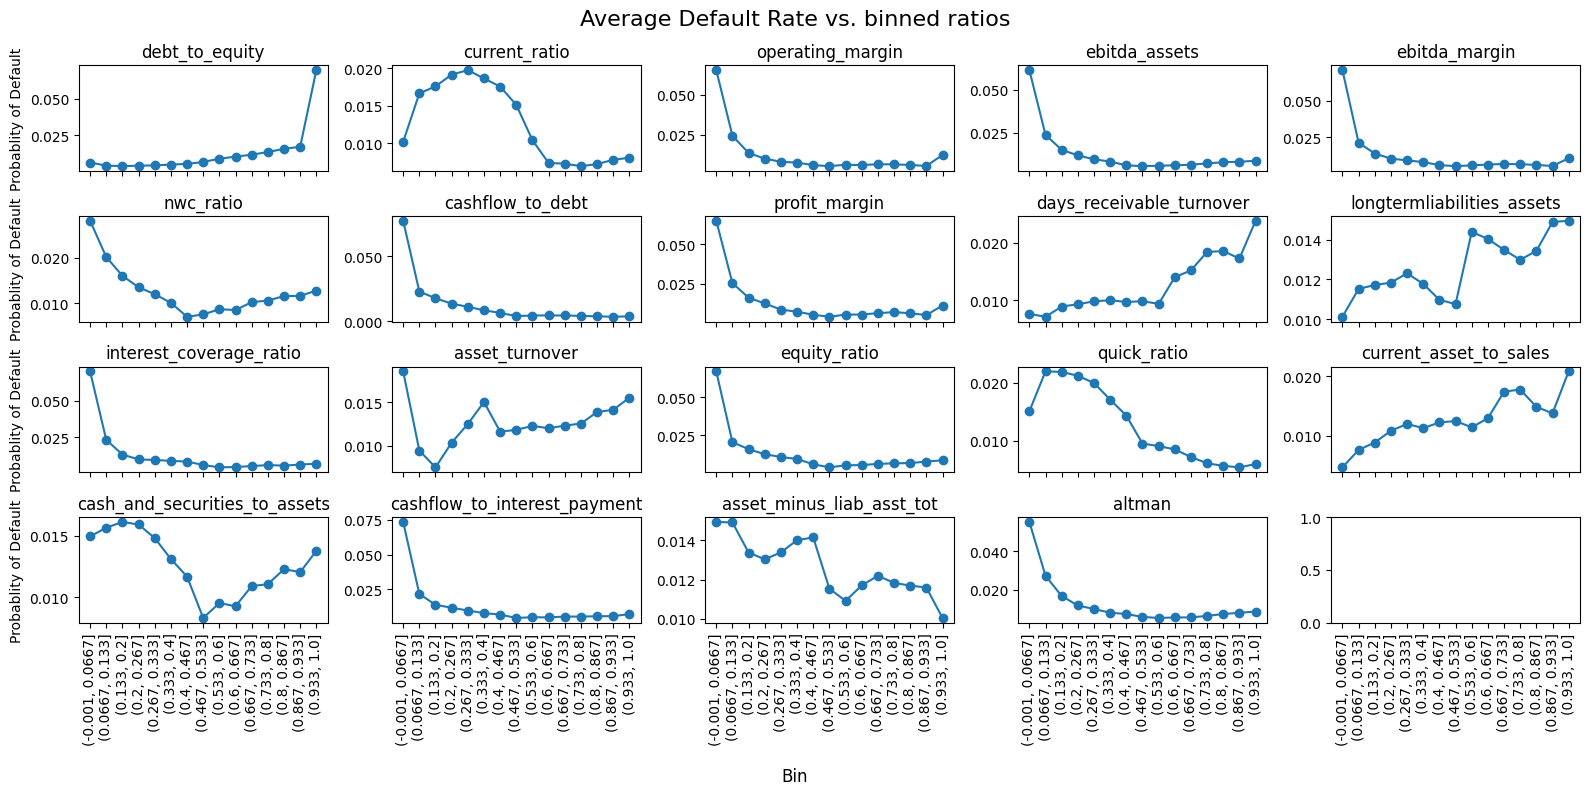

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import FormatStrFormatter

preprocessor = loaded_estimator.preprocessor

num_bins = 15
num_cols = len(preprocessor.ratio_cols)
nrows = (int)(np.sqrt(num_cols))
ncols = (int)(math.ceil(num_cols / nrows))
fig, axes = plt.subplots(figsize=(16, 8), nrows=nrows, ncols=ncols, sharex=True)
for i, column in enumerate(preprocessor.ratio_cols):
    ax_row = i // ncols
    ax_col = i % ncols
    data = preprocessor.df_[[column, 'label']].copy() # extract the dataframe used for training
    data['bins'] = pd.cut(data[column], bins=num_bins)

    bin_summary = data.groupby('bins')['label'].mean()
    axes[ax_row][ax_col].plot(bin_summary.index.astype(str), bin_summary.values, marker='o')
    axes[ax_row][ax_col].set_title(column)
    axes[ax_row][ax_col].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    if ax_row == nrows - 1:
        axes[ax_row][ax_col].tick_params(axis='x', rotation=90)
    if ax_col == 0:
        axes[ax_row][ax_col].set_ylabel('Probablity of Default')
    # if all ratios are plotted, clean the rest of the empty subplot frame(s)
    if i == num_cols - 1:
        i += 1
        while i < nrows * ncols:
            ax_row = i // ncols
            ax_col = i % ncols
            if ax_row == nrows - 1:
                axes[ax_row][ax_col].tick_params(axis='x', rotation=90) 
            i += 1
fig.suptitle("Average Default Rate vs. binned ratios", fontsize=16)
fig.supxlabel("Bin")
fig.tight_layout()

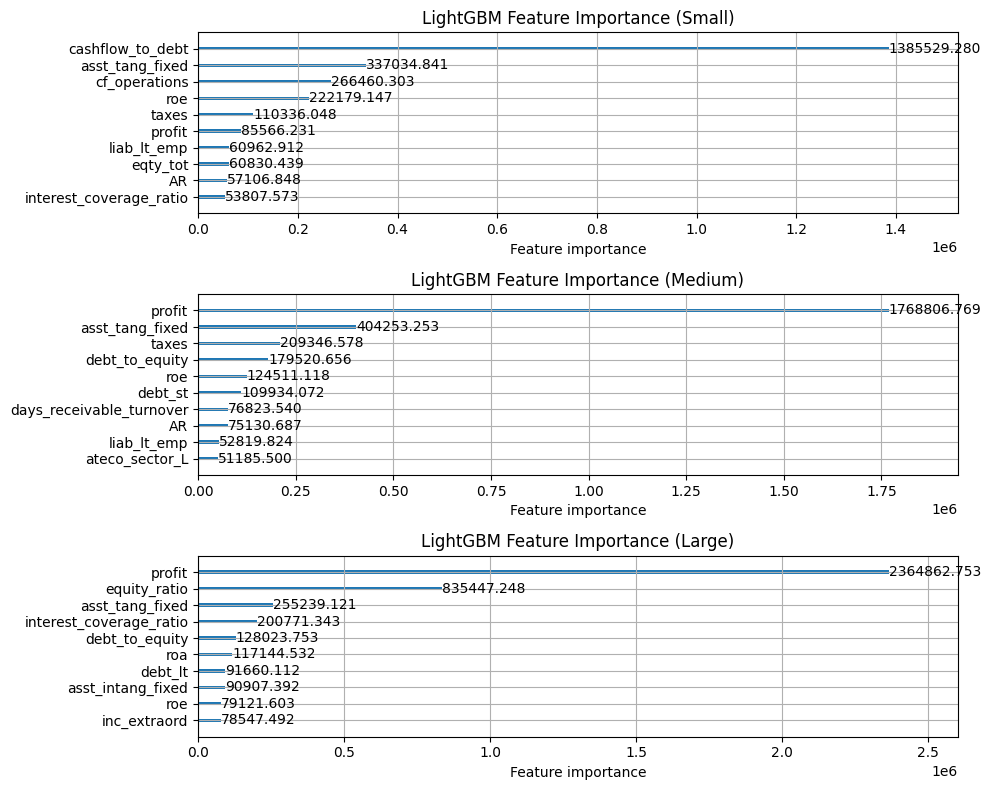

In [18]:
fig, ax = plt.subplots(figsize=(10, 8), nrows=3, ncols=1)
max_num_features = 10
importance_type = 'gain'
for i, row in loaded_estimator.models.iloc[[2,5,8]].reset_index().iterrows():
    title = {0: "Small", 1: "Medium", 2: "Large"}
    lgb.plot_importance(booster=row['model'], 
                        ax=ax[i],
                        importance_type=importance_type, 
                        title=f"LightGBM Feature Importance ({title[i]})", 
                        max_num_features=max_num_features,
                        ylabel=None)
plt.tight_layout()

In [19]:
import shap

df_ = loaded_estimator.preprocessor.df_

fig, axes = plt.subplots(nrows=3, ncols=1)

for group in loaded_estimator.models['size_group'].drop_duplicates().sort_values():
    mask = df_[loaded_estimator.group_col] == group
    t = df_[mask][loaded_estimator.predictors]
    m = {0: 2, 1: 5, 2: 8} # map the group to model index
    explainer = shap.TreeExplainer(loaded_estimator.models.iloc[m[group]]['model'])
    shap_values = explainer(t.sample(1000))
    
    max_display = 10
    plot_size = 1
    plt.sca(axes[group])
    shap.summary_plot(shap_values, max_display=max_display, plot_size=plot_size, show=False)
    title = {0: "Small", 1: "Medium", 2: "Large"}
    plt.title(title[group], fontsize=16)

plt.show()

ModuleNotFoundError: No module named 'shap'

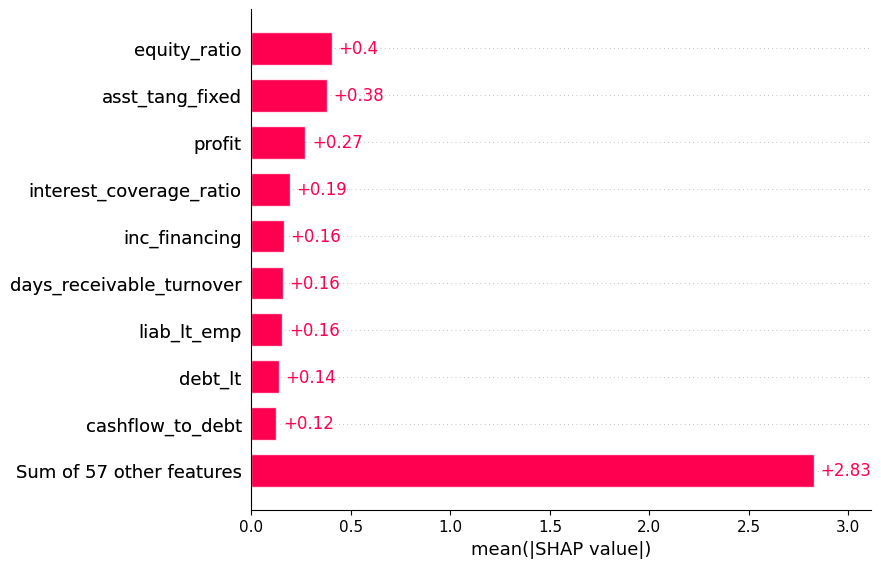

In [ ]:
shap.plots.bar(shap_values, max_display=10)

In [ ]:
# m = {loaded_estimator.predictors[i]: i for i in range(len(loaded_estimator.predictors))}

In [ ]:
# shap.plots.scatter(shap_values[:, m['asst_tang_fixed']])
# shap.plots.scatter(shap_values[:, m['asst_tang_fixed']], color=shap_values)
# shap.plots.beeswarm(shap_values, show=False)

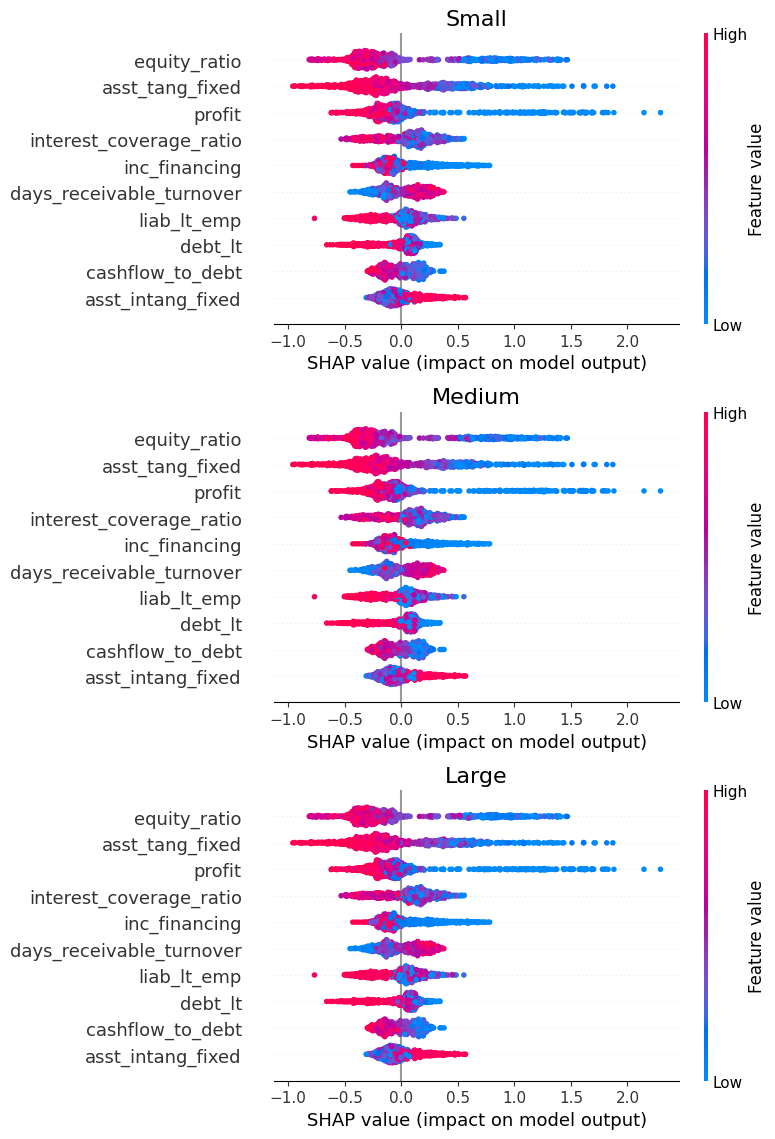

In [ ]:
max_display = 10
plot_size = 1
fig, axes = plt.subplots(nrows=3, ncols=1)
plt.sca(axes[0])
shap.summary_plot(shap_values, max_display=max_display, plot_size=plot_size, show=False)
plt.title("Small", fontsize=16)
plt.sca(axes[1])
shap.summary_plot(shap_values, max_display=max_display, plot_size=plot_size, show=False)
plt.title("Medium", fontsize=16)
plt.sca(axes[2])
shap.summary_plot(shap_values, max_display=max_display, plot_size=plot_size, show=False)
plt.title("Large", fontsize=16)
plt.show()
# shap.summary_plot(shap_values, max_display=max_display)
# plt.sca(axes[1])
# shap.summary_plot(shap_values, max_display=max_display, show=False)
# plt.sca(axes[2])
# shap.summary_plot(shap_values, max_display=max_display)
# plt.tight_layout()

In [ ]:
shap.summary_plot(title)

In [ ]:
shap.summary_plot()

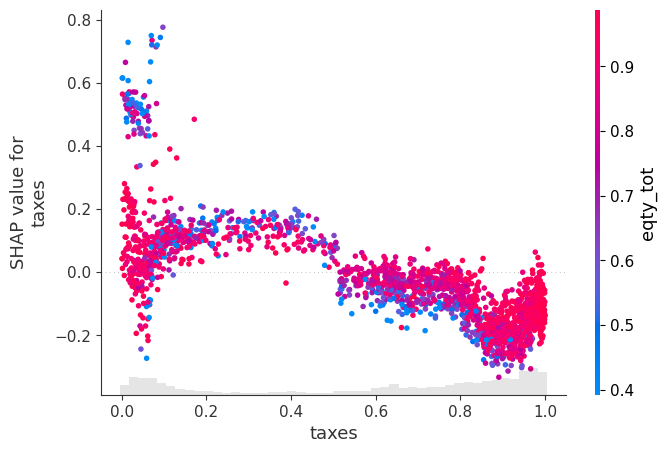

In [ ]:
shap.plots.scatter(shap_values[:, m['taxes']], color=shap_values)

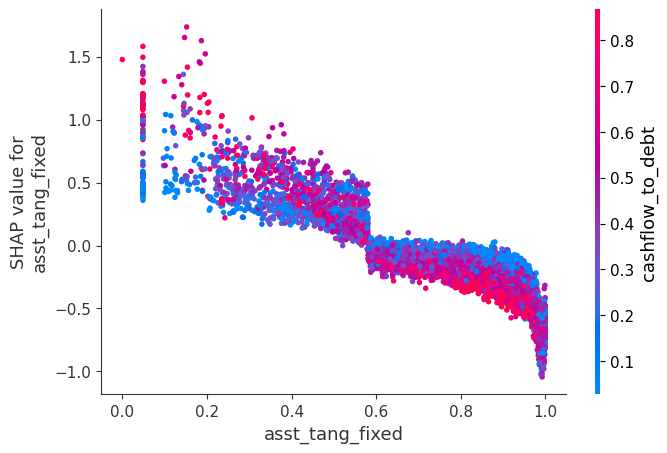

In [ ]:
shap.dependence_plot("asst_tang_fixed", shap_values, t.iloc[:10000,:])

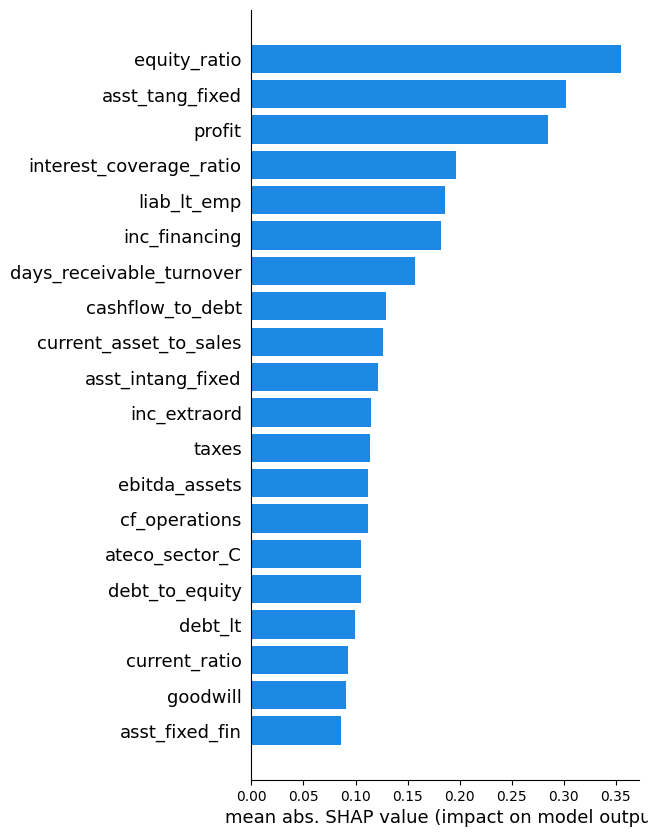

In [ ]:
# # make a bar chart that shows the global importance of the top 20 features
# inds = np.argsort(-global_importances)
# f = plt.figure(figsize=(5,10))
# y_pos = np.arange(20)
# inds2 = np.flip(inds[:20], 0)
# plt.barh(y_pos, global_importances[inds2], align='center', color="#1E88E5")
# plt.yticks(y_pos, fontsize=13)
# plt.gca().set_yticklabels(t.columns[inds2])
# plt.xlabel('mean abs. SHAP value (impact on model output)', fontsize=13)
# plt.gca().xaxis.set_ticks_position('bottom')
# plt.gca().yaxis.set_ticks_position('none')
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit

rfecv = RFECV(
    estimator=LogisticRegression(solver='sag'),
    step=1,
    cv=TimeSeriesSplit(3),
    scoring="roc_auc",
    min_features_to_select=1,
    n_jobs=2,
)
data = preprocessor.df_.sort_values(by='stmt_date')
subset = data[preprocessor.ratio_cols + [preprocessor.target]]
X = subset.drop(preprocessor.target, axis=1)
y = subset[preprocessor.target]
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")
display(rfecv.get_feature_names_out())

Optimal number of features: 9


array(['debt_to_equity', 'ebitda_assets', 'cashflow_to_debt',
       'profit_margin', 'days_receivable_turnover',
       'longtermliabilities_assets', 'asset_turnover',
       'current_asset_to_sales', 'asset_minus_liab_asst_tot'],
      dtype=object)

: 

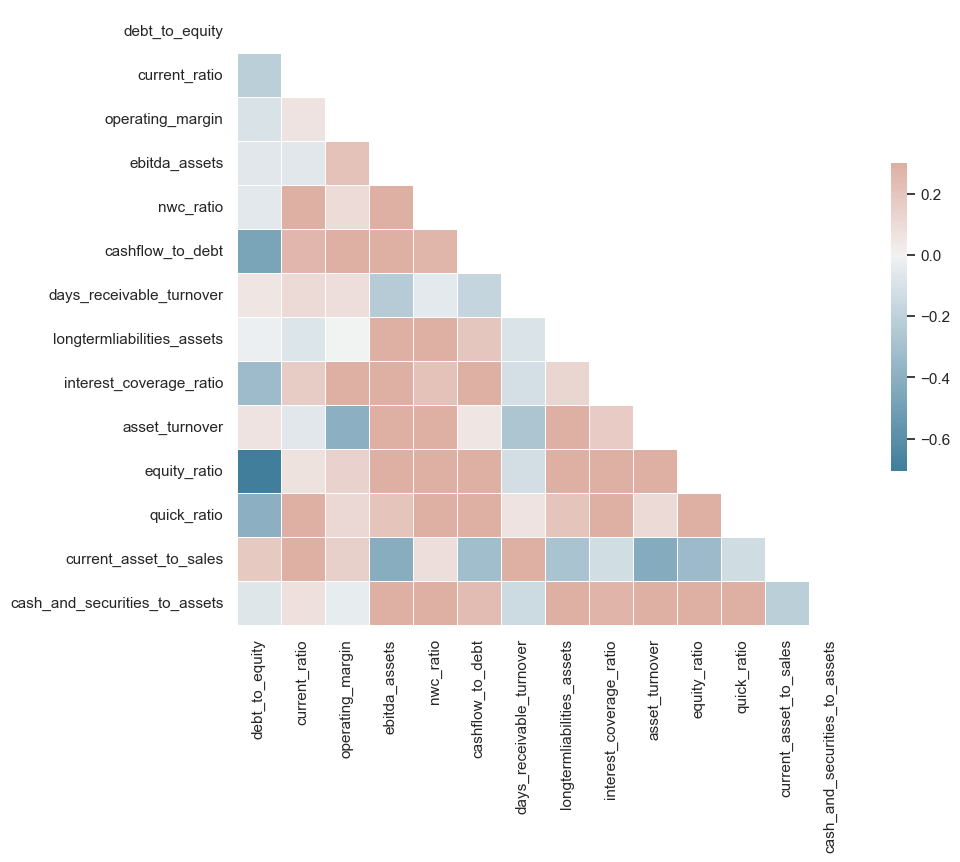

: 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cols = a.columns

d = preprocessor.df_[cols]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

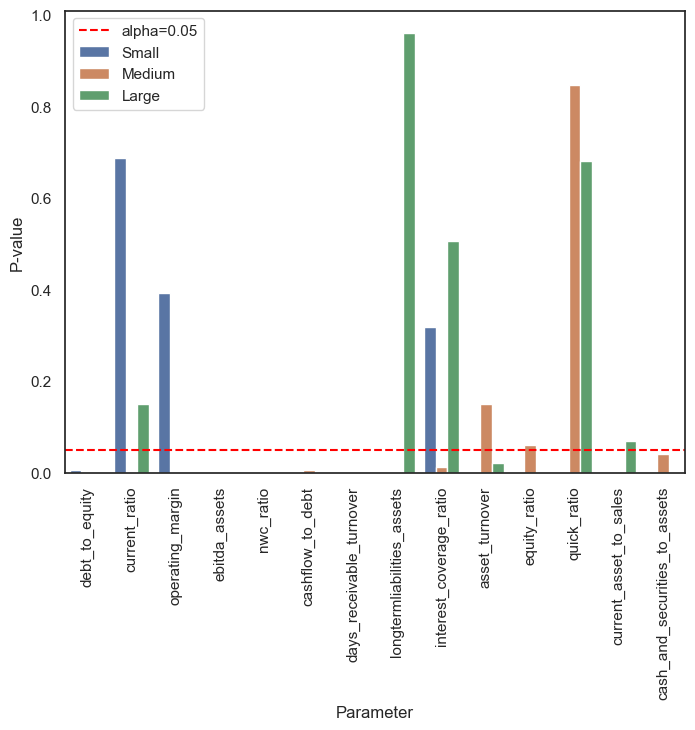

: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

t = pd.DataFrame()
alpha = 0.05
for group in model_list[-1]['size_group']:
    subset = model_list[-1][model_list[-1]['size_group'] == group]
    model = subset['model'].item()
    names = {0: 'Small', 1: 'Medium', 2: 'Large', -1: 'All'}
    t = pd.concat((t, pd.Series(model.pvalues[cols], name=names[group])), axis=1)
t = t.reset_index()

t_long = pd.melt(t, id_vars="index", var_name="Size", value_name="P-value")
t_long = t_long.rename(columns={"index": "Parameter"})
plt.figure(figsize=(8,6))
sns.barplot(data=t_long, x='Parameter', y='P-value', hue='Size')
plt.axhline(alpha, color='red', linestyle='--', label=f'alpha={alpha}')
plt.legend()
plt.xticks(rotation=90);

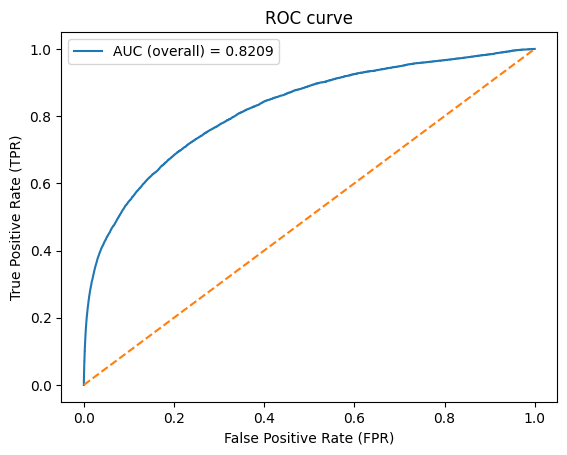

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Calculate overall AUC
overall_auc = roc_auc_score(stats_list, predictions)

fpr, tpr, _ = roc_curve(stats_list, predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC (overall) = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()

True label: 1
Prediction: 4.8793602478453416e-05
The original data:


,Unnamed: 0,id,stmt_date,HQ_city,legal_struct,ateco_sector,def_date,fs_year,asst_intang_fixed,asst_tang_fixed,...,inc_extraord,taxes,profit,days_rec,ebitda,roa,roe,wc_net,margin_fin,cf_operations
965170,4473814,1918840180,2008-12-31,18.0,SRU,86.0,03/03/2010,2008,6889029.0,745860.0,...,50315.0,151840.0,108082.0,NaN,99076.0,1.22,3.78,253971.0,-4774827.0,108082.0


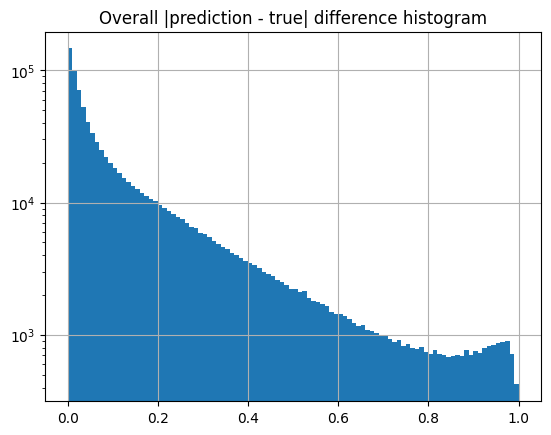

In [21]:
# Investigate the worst-performing prediction
t = predictions.set_axis(stats_list.index) # align the loc index of predictions (may not start from 0)
order = np.argsort(abs(stats_list-t)) # obtain the iloc index of the maximum difference (start from 0)
index = stats_list.index[order.iloc[-1]] # obtain the loc index of the original data (may not start from 0)
print(f"True label: {stats_list[index]}")
print(f"Prediction: {t.loc[index]}")
print("The original data:")
display(df.loc[[index]])
abs(stats_list-t).hist(bins=100, log=True)
plt.title("Overall |prediction - true| difference histogram");